# XAI pipeline

- clone the repository
- use python3.12.9
- create a virtual environment, activate it
- pip install -r requirements.txt

- add or swap datasets in the 2nd cell

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet

import shap
import lime
import dice_ml
from anchor import anchor_tabular

c:\Users\Dani\OneDrive - Tilburg University\CSAI\Semester 5\xai\repo\XAI\xaienv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# swap or add new datasets here

# 1. change dataset variable to new dataset name
# 2. add else block for new dataset name
# 3. specify path
# 4. data = pd.read_csv(path)
# 5. specify target_column and id_column if applicable
# 6. do any dataset-specific preprocessing if needed -> binarize the target, cast categorical features if the intended classifier needs it

dataset = "migraine"  # options: "breast_cancer_wisconsin", "student_dropout", "brain_tumor", "phishing"
# larger datasets are not in the repo, but can be downloaded from the links in datasets.md

if dataset == "breast_cancer_wisconsin":
    path = pathlib.Path("../datasets/breast_cancer_wisconsin.csv" \
    "")
    data = pd.read_csv(path)

    target_column = "diagnosis"
    id_column = "id"

    # Remove the last column because it was empty and unnamed
    data = data.iloc[:, :-1]

elif dataset == "student_dropout":
    path = pathlib.Path("../datasets/student_dropout.csv")
    data = pd.read_csv(path)

    target_column = "Target"

    # remove graduated students
    data = data[data["Target"] != "Graduate"]

elif dataset == "glioma":
    path = pathlib.Path("../datasets/TCGA_InfoWithGrade.csv")
    data = pd.read_csv(path)
    
    target_column = "Grade"

# not done yet
elif dataset == "phishing":
    path = pathlib.Path("../datasets/PhiUSIIL_Phishing_URL_Dataset.csv")
    data = pd.read_csv(path)
    target_column = "label"

    # remove column "FILENAME", "URL", "Domain", "Title"
    data = data.drop(columns=["FILENAME", "URL", "Domain", "Title"])

    # map the TLD columns strings to integers based on frequency
    tld_counts = data["TLD"].value_counts()
    tld_mapping = {tld: i for i, (tld, _) in enumerate(tld_counts.items())}
    data["TLD"] = data["TLD"].map(tld_mapping)

elif dataset == "appointments":
    path = pathlib.Path("../datasets/appointments_data_preprocessed.csv")
    data = pd.read_csv(path)

    target_column = "appointment_was_honored"

elif dataset == "migraine":
    path = pathlib.Path("../datasets/synthetic_migraine_data.csv")
    data = pd.read_csv(path)
    #data = data[data["user_id"] == 1]
    # convert timestamp to float
    data["timestamp"] = pd.to_datetime(data["timestamp"]).astype(int) / 10**9
    # normalize all columns except target_column and user_id to [-1, 1]
    for col in data.columns:
        if col not in ["migraine_at_the_moment", "user_id"]:
            data[col] = 2 * ((data[col] - data[col].min()) / (data[col].max() - data[col].min())) - 1

    target_column = "label"

## Modelling

### Train test split with ADASYN

In [3]:
X = data.drop(columns=[target_column]) #, "attendance_rate_to_date", "attendance_rate_to_date", "num_attended_appointments_to_date", "first_donation"])
y = data[target_column]

# Use LabelEncoder to convert string labels to numeric
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Convert back to pandas Series to maintain index
y = pd.Series(y_encoded, index=y.index)

# determine number of samples per class for the test set
minority_class_count = Counter(y)[1]
if minority_class_count < 200:
    samples_per_class = 100
else:
    samples_per_class = minority_class_count // 3

# Separate data by class using the encoded numeric labels
class_0_indices = y[y == 0].index  # First class (alphabetically)
class_1_indices = y[y == 1].index  # Second class (alphabetically)
print(f"Available samples - Class 0: {len(class_0_indices)}, Class 1: {len(class_1_indices)}")
# Check if we have enough samples
if len(class_0_indices) < samples_per_class or len(class_1_indices) < samples_per_class:
    print(f"Warning: Not enough samples in one or both classes!")
    samples_per_class = min(len(class_0_indices), len(class_1_indices))
    print(f"Adjusting to {samples_per_class} samples per class")

# Randomly sample from each class
np.random.seed(42)  # For reproducibility
test_indices_class_0 = np.random.choice(class_0_indices, size=samples_per_class, replace=False)
test_indices_class_1 = np.random.choice(class_1_indices, size=samples_per_class, replace=False)
# Combine test indices
test_indices = np.concatenate([test_indices_class_0, test_indices_class_1])
# Create test set
X_test = X.loc[test_indices]
y_test = y.loc[test_indices]
# Create training set (remaining samples)
train_indices = X.index.difference(test_indices)
X_train = X.loc[train_indices]
y_train = y.loc[train_indices]

# Remove "id" column from both training and test sets

# if variable id_column is defined
if 'id_column' in locals() and id_column in X_train.columns:
    X_train = X_train.drop(columns=[id_column])
    X_test = X_test.drop(columns=[id_column])

# Print class distribution before oversampling
print(f"\nTraining set class distribution before oversampling:")
print(Counter(y_train))
print(f"Training set shape: {X_train.shape}")

print(f"\nTest set class distribution:")
print(Counter(y_test))
print(f"Test set shape: {X_test.shape}")

# Create validation set from the test set with 50-50 samples from each class
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Print class distribution of validation set
print(f"\nValidation set class distribution:")
print(Counter(y_val))

# count samples in each class in y_train, if there are more than 2000 samples in both classes, randomly sample 2000 from each class
# adasyn naming is missleading here, because we might not apply ADASYN if there are already enough samples
train_class_counts = Counter(y_train)
if train_class_counts[0] > 2000 and train_class_counts[1] > 2000:
    print(f"\nTraining set has more than 2000 samples in both classes, downsampling to 2000 samples per class")
    class_0_indices = y_train[y_train == 0].index
    class_1_indices = y_train[y_train == 1].index
    sampled_class_0_indices = np.random.choice(class_0_indices, size=2000, replace=False)
    sampled_class_1_indices = np.random.choice(class_1_indices, size=2000, replace=False)
    sampled_indices = np.concatenate([sampled_class_0_indices, sampled_class_1_indices])
    X_train_adasyn = X_train.loc[sampled_indices]
    y_train_adasyn = y_train.loc[sampled_indices]
    print(f"Training set shape after downsampling: {X_train.shape}")

else:
    # Apply ADASYN to training set to address class imbalance
    adasyn = ADASYN(random_state=42)
    X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

    # Print class distribution after ADASYN
    print(f"\nTraining set class distribution after ADASYN:")
    print(Counter(y_train_adasyn))
    print(f"Training set shape after ADASYN: {X_train_adasyn.shape}")

# Show the actual label mapping used by LabelEncoder
print(f"\nLabelEncoder mapping:")
for encoded_label, original_label in enumerate(label_encoder.classes_):
    count_in_training = list(y_train_adasyn).count(encoded_label)
    print(f"{original_label} -> {encoded_label}: {count_in_training} samples in training set")

print(f"\nFinal training labels distribution:")
print(Counter(y_train_adasyn))
print(f"Final test labels distribution:")
print(Counter(y_test))

# Function to convert predictions back to original labels if needed
def decode_predictions(encoded_predictions):
    """Convert encoded predictions back to original string labels"""
    return label_encoder.inverse_transform(encoded_predictions)

print(f"\nLabelEncoder classes: {label_encoder.classes_}")
print(f"To decode predictions later, use: label_encoder.inverse_transform(predictions)")

Available samples - Class 0: 416930, Class 1: 108670

Training set class distribution before oversampling:
Counter({0: 380707, 1: 72447})
Training set shape: (453154, 16)

Test set class distribution:
Counter({0: 36223, 1: 36223})
Test set shape: (72446, 16)

Validation set class distribution:
Counter({1: 18112, 0: 18111})

Training set has more than 2000 samples in both classes, downsampling to 2000 samples per class
Training set shape after downsampling: (453154, 16)

LabelEncoder mapping:
-1.0 -> 0: 2000 samples in training set
1.0 -> 1: 2000 samples in training set

Final training labels distribution:
Counter({0: 2000, 1: 2000})
Final test labels distribution:
Counter({0: 18112, 1: 18111})

LabelEncoder classes: [-1.  1.]
To decode predictions later, use: label_encoder.inverse_transform(predictions)


### MODEL

c:\Users\Dani\OneDrive - Tilburg University\CSAI\Semester 5\xai\repo\XAI\xaienv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:04:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9636970985285592


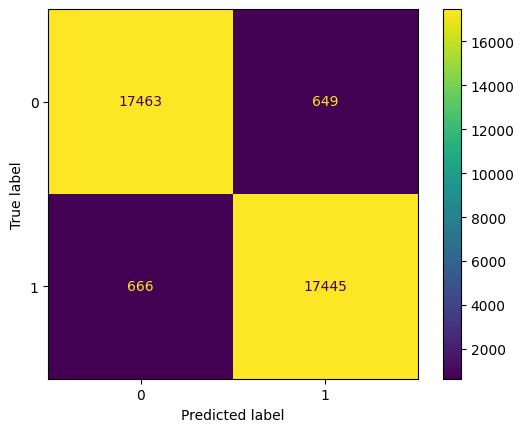

Precision: 0.9641317563833315
Recall: 0.963226768262382
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     18112
           1       0.96      0.96      0.96     18111

    accuracy                           0.96     36223
   macro avg       0.96      0.96      0.96     36223
weighted avg       0.96      0.96      0.96     36223



In [ ]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_adasyn.values, y_train_adasyn)

accuracy = model.score(X_test.values, y_test)
print(f"Accuracy: {accuracy}")

y_pred = model.predict(X_test.values)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# i am interested in what proportion of the the predicted migraine instances are actual migraine instances
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# put a classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


In [5]:
# plot the distribution of all features

# combine X_train_adasyn, X_test, and X_val for, Y_train_adasyn, y_test, and y_val for data

data_adasyn = pd.concat([X_train_adasyn, X_test, X_val], axis=0)
data_adasyn[target_column] = pd.concat([y_train_adasyn, y_test, y_val], axis=0)

X_adasyn = data_adasyn.drop(columns=[target_column])
y_adasyn = data_adasyn[target_column]


### Beeswarm

In [6]:
# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for a subset of test data (for performance)
# Using a sample to make the plot more readable
# sample_size = min(100, len(X_test))
X_sample = X_test.sample(n=len(X_test), random_state=42)
shap_values = explainer.shap_values(X_adasyn)

# If binary classification, shap_values might be 3D array
if len(shap_values.shape) == 3:
    # For binary classification, use the positive class (index 1)
    shap_values_to_plot = shap_values[:, :, 1]
else:
    shap_values_to_plot = shap_values

C:\Users\Dani\AppData\Local\Temp\ipykernel_106448\679169148.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_to_plot, X_adasyn, plot_type="dot", max_display=30, show=False)


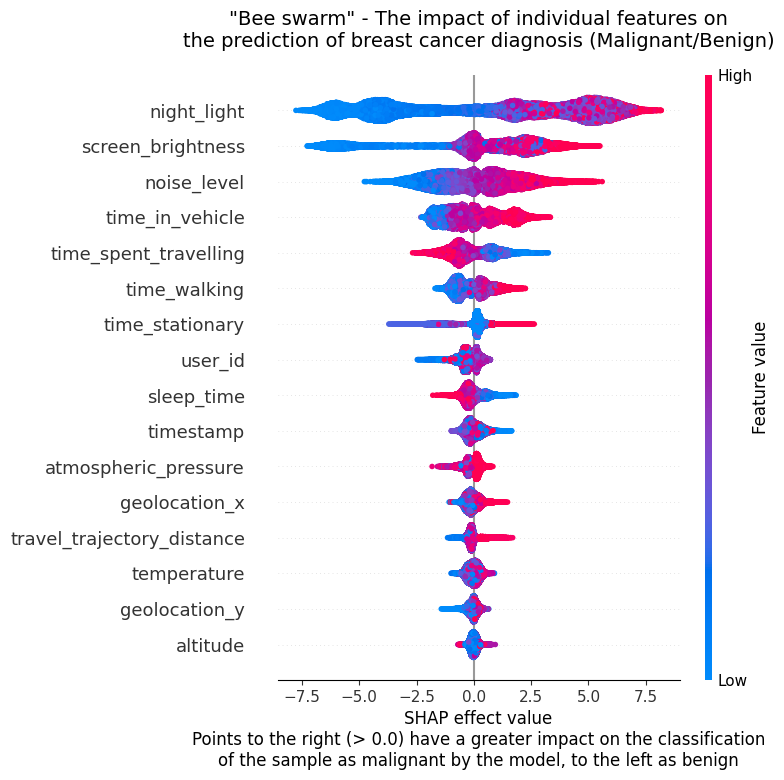

In [7]:
# TODO: add legend to the plot

# Create the bee swarm plot with all features
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_to_plot, X_adasyn, plot_type="dot", max_display=30, show=False)

# Customize the plot to match the style of your reference image
plt.title('"Bee swarm" - The impact of individual features on\nthe prediction of breast cancer diagnosis (Malignant/Benign)', 
          fontsize=14, pad=20)
plt.xlabel('SHAP effect value\nPoints to the right (> 0.0) have a greater impact on the classification\nof the sample as malignant by the model, to the left as benign', 
           fontsize=12)
plt.ylabel('')

# Add feature value legend
# plt.text(0.02, 0.98, 'Legend:\nHigh = high value of the feature\nLow = low value of the feature', 
#         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
#         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Legend:
- High = high value of the feature, e.g., "cap_diameter_cm" (High) = large cap diameter in cm
- Low = low value of the feature, e.g., "stem_height_cm" (Low) = short stem
- "0" = the boundary between features that have significant and small importance in determining the edibility of the mushroom
- For binary features (either present or absent), high value (High), i.e., the red color, means: "the feature is present." 

In [8]:
# Calculate mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values_to_plot).mean(axis=0)
# Get feature names (assuming X_adasyn is a pandas DataFrame)
feature_names = X_adasyn.columns.tolist()
# Create a DataFrame to pair features with their importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_shap_values
})
# Sort by importance and get top 3
top_3_features = feature_importance.sort_values('mean_abs_shap', ascending=False).head(3)

print("Top 3 most important features:")
for i, row in top_3_features.iterrows():
    print(f"{row['feature']}: {row['mean_abs_shap']:.4f}")

# Just the names as a list
top_3_names = top_3_features['feature'].tolist()

Top 3 most important features:
night_light: 3.8923
screen_brightness: 2.1548
noise_level: 1.4252


### Waterfall

In [9]:
instance_idx = 7100

# Get the expected value (baseline)
if hasattr(explainer.expected_value, '__len__') and len(explainer.expected_value) > 1:
    expected_value = float(explainer.expected_value[1])  # For malignant class
else:
    expected_value = float(explainer.expected_value)

# Select a specific instance to explain (you can change this index)
instance_data = X_test.iloc[instance_idx]
instance_shap_values = shap_values_to_plot[instance_idx]

# Get model prediction for this instance
prediction = model.predict_proba(X_test.iloc[[instance_idx]])[0, 1]

print(f"\nAnalyzing instance {instance_idx}:")
print(f"Actual diagnosis: {y_test.iloc[instance_idx]}")
print(f"Predicted probability of Malignant: {prediction:.3f}")
print(f"Expected value (baseline): {expected_value:.3f}\n")

# -------- TABLE INSTEAD OF PLOT --------

# Build a DataFrame with feature values and SHAP contributions
shap_df = pd.DataFrame({
    "feature": instance_data.index,
    "value": instance_data.values,
    "shap_value": instance_shap_values,
})

# Direction of effect
shap_df["impact_direction"] = np.where(
    shap_df["shap_value"] >= 0,
    "Increases migraine risk",
    "Decreases migraine risk"
)

# Sort by absolute impact and keep top N (e.g. 10)
shap_df["abs_shap"] = shap_df["shap_value"].abs()
shap_df = shap_df.sort_values("abs_shap", ascending=False)

top_n = 10
display_cols = ["feature", "value", "shap_value", "impact_direction"]
# or, if not in Jupyter, use:
# print(shap_df[display_cols].head(top_n).to_string(index=False))


# sum all rows except the first 3 rows for value and shap_value columns and put the values in row 4
# remove the row with value "user_id" in "feature" column
shap_df = shap_df[shap_df["feature"] != "user_id"]
val, sh = shap_df[display_cols].iloc[3:].sum(numeric_only=True)
shap_df
# keep only the first 3 rows
shap_df = shap_df.iloc[:3]
shap_df = pd.concat([shap_df, pd.DataFrame([{"feature": "Other factors", "value": val, "shap_value": sh, "impact_direction": "Mixed impact"}])], ignore_index=True)
# remove last column
shap_df = shap_df.drop(columns=["abs_shap"])
# rename last columns as impact
shap_df = shap_df.rename(columns={"impact_direction": "impact"})
# change the value of column "impact" to + if shap_value > 0, - if shap_value < 0, 0 if shap_value == 0
shap_df["impact"] = shap_df["shap_value"].apply(lambda x: "+" if x > 0 else ("-" if x < 0 else "0"))
# dispay value and shap_value columns rounded to 3 decimal places
shap_df[["value", "shap_value"]] = shap_df[["value", "shap_value"]].round(2)
# value is displayed in the format 6.2900e+00 change it to 6.29
shap_df["value"] = shap_df["value"].apply(lambda x: f"{x:.2f}")
shap_df


Analyzing instance 7100:
Actual diagnosis: 1
Predicted probability of Malignant: 1.000
Expected value (baseline): -0.030



,feature,value,shap_value,impact
0,night_light,0.10,-3.81,-
1,time_in_vehicle,0.07,-1.58,-
2,noise_level,-0.15,-1.33,-
3,Other factors,-2.60,-1.84,-


In [12]:
# save shap_df to csv
shap_df.to_csv("shap_migraine_instance_analysis.csv", index=False)

### Lime


Analyzing instance 7100:
Actual diagnosis: 1
Predicted probabilities - Benign: 0.000, Malignant: 1.000


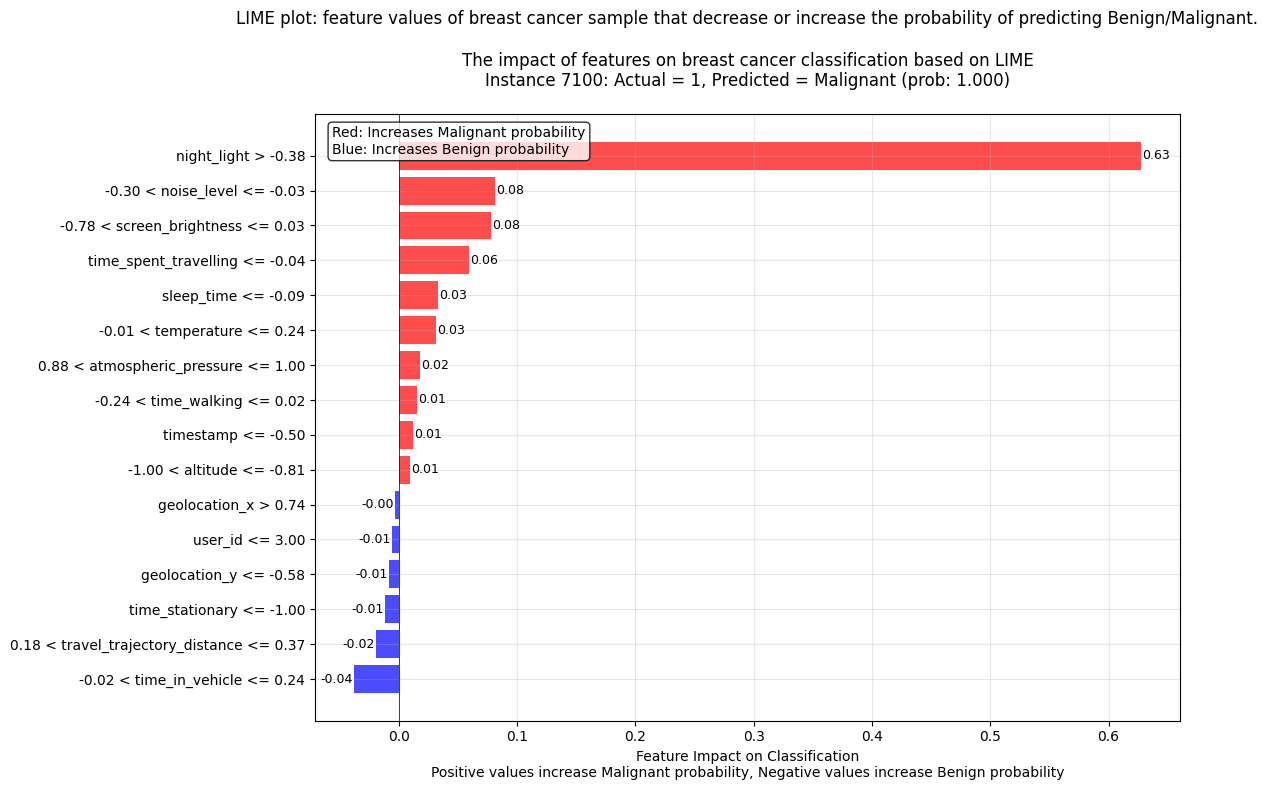

In [10]:
# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['Benign', 'Malignant'],
    mode='classification',
    discretize_continuous=True
)

# Select an instance to explain (you can change this)
instance = X_test.iloc[instance_idx].values

print(f"\nAnalyzing instance {instance_idx}:")
print(f"Actual diagnosis: {y_test.iloc[instance_idx]}")

# Get model prediction for this instance
prediction = model.predict_proba([instance])[0]
print(f"Predicted probabilities - Benign: {prediction[0]:.3f}, Malignant: {prediction[1]:.3f}")

# Generate LIME explanation
explanation = explainer.explain_instance(
    instance, 
    model.predict_proba, 
    num_features=30,  # Show top 15 features
    top_labels=2
)

# Get the explanation data
exp_data = explanation.as_list()
exp_data.sort(key=lambda x: x[1], reverse=True)  # Sort by importance

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

features = []
values = []
colors = []

for feature, importance in exp_data:
    features.append(feature)
    values.append(importance)
    colors.append('red' if importance > 0 else 'blue')

# Create horizontal bar chart
y_pos = np.arange(len(features))
bars = ax.barh(y_pos, values, color=colors, alpha=0.7)

# Customize the plot
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()  # Top feature at the top
ax.set_xlabel('Feature Impact on Classification\nPositive values increase Malignant probability, Negative values increase Benign probability')
ax.set_title(f'LIME plot: feature values of breast cancer sample that decrease or increase the probability of predicting Benign/Malignant.\n\n'
             f'The impact of features on breast cancer classification based on LIME\n'
             f'Instance {instance_idx}: Actual = {y_test.iloc[instance_idx]}, '
             f'Predicted = {"Malignant" if prediction[1] > 0.5 else "Benign"} '
             f'(prob: {max(prediction):.3f})', 
             fontsize=12, pad=20)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, values)):
    width = bar.get_width()
    ax.text(width + (0.001 if width >= 0 else -0.001), 
            bar.get_y() + bar.get_height()/2, 
            f'{value:.2f}', 
            ha='left' if width >= 0 else 'right', 
            va='center',
            fontsize=9)

# Add vertical line at x=0
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Add legend
ax.text(0.02, 0.98, 'Red: Increases Malignant probability\nBlue: Increases Benign probability', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

### Counterfactual analysis

In [24]:
# Prepare data for DiCE
# Create a combined dataset for DiCE
train_data = X_train_adasyn.copy()
train_data['diagnosis'] = y_train_adasyn

# Initialize DiCE
dice_data = dice_ml.Data(dataframe=train_data, 
                        continuous_features=list(X_train_adasyn.columns),
                        outcome_name='diagnosis')

# Create DiCE model
dice_model = dice_ml.Model(model=model, backend="sklearn")

# Create DiCE explainer
explainer = dice_ml.Dice(dice_data, dice_model, method="random")

# Select a test instance (preferably one with negative outcome)
test_instance = X_test.iloc[0:1]  # First test instance

# Generate counterfactuals
counterfactuals = explainer.generate_counterfactuals(
    test_instance, 
    total_CFs=5,  # Number of counterfactuals to generate
    desired_class="opposite"  # Generate opposite class
)

# Display results
print("Counterfactual Analysis Results:")
print("=" * 50)

# Get the original instance
original = test_instance.iloc[0]
original_prediction = model.predict(test_instance)[0]

print(f"Original Instance Prediction: {original_prediction}")
print("\nCounterfactuals found:")

# Display counterfactuals in comparison format
cf_examples = counterfactuals.cf_examples_list[0].final_cfs_df

if not cf_examples.empty:
    print(f"\nComparison with Instance #0:")
    print("Feature" + " " * 35 + "Original Value" + " " * 15 + "Modified Value")
    print("-" * 90)
    
    for feature in X_train.columns:
        original_val = original[feature]
        modified_val = cf_examples.iloc[0][feature]
        
        # Format values
        if isinstance(original_val, (int, float)):
            orig_str = f"{original_val:.2f}" if abs(original_val) < 1000 else f"{original_val:.0f}"
            mod_str = f"{modified_val:.2f}" if abs(modified_val) < 1000 else f"{modified_val:.0f}"
        else:
            orig_str = str(original_val)
            mod_str = str(modified_val)
        
        # Show changes
        if abs(float(original_val) - float(modified_val)) > 0.01:
            print(f"{feature:<40} {orig_str:<25} -> {mod_str}")
        else:
            print(f"{feature:<40} {orig_str:<25}")

else:
    print("No counterfactuals generated. Trying different parameters...")
    
    # Try with different parameters
    counterfactuals = explainer.generate_counterfactuals(
        test_instance, 
        total_CFs=3,
        desired_class="opposite",
        proximity_weight=0.2,
        diversity_weight=1.0
    )
    
    cf_examples = counterfactuals.cf_examples_list[0].final_cfs_df
    
    if not cf_examples.empty:
        print(f"\nComparison with Instance #0:")
        print("Feature" + " " * 35 + "Original Value" + " " * 15 + "Modified Value")
        print("-" * 90)
        
        for feature in X_train.columns:
            original_val = original[feature]
            modified_val = cf_examples.iloc[0][feature]
            
            if isinstance(original_val, (int, float)):
                orig_str = f"{original_val:.2f}"
                mod_str = f"{modified_val:.2f}"
            else:
                orig_str = str(original_val)
                mod_str = str(modified_val)
            
            if abs(float(original_val) - float(modified_val)) > 0.01:
                print(f"{feature:<40} {orig_str:<25} -> {mod_str}")
            else:
                print(f"{feature:<40} {orig_str:<25}")

  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Dani\OneDrive - Tilburg University\CSAI\Semester 5\xai\repo\XAI\xaienv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\Dani\OneDrive - Tilburg University\CSAI\Semester 5\xai\repo\XAI\xaienv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\Dani\OneDrive - Tilburg University\CSAI\Semester 5\xai\repo\XAI\xaienv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\Dani\OneDrive - Tilburg University\CSAI\Semester 5\xai\repo\XAI\xaienv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without featur

Counterfactual Analysis Results:
Original Instance Prediction: 0

Counterfactuals found:

Comparison with Instance #0:
Feature                                   Original Value               Modified Value
------------------------------------------------------------------------------------------
timestamp                                1728382200               
user_id                                  1.00                     
altitude                                 -100.00                  
geolocation_x                            -33.57                   
geolocation_y                            8.90                     
atmospheric_pressure                     100000                   
temperature                              -0.10                    
screen_brightness                        59.12                    
night_light                              2.41                      -> 99.50
noise_level                              58.14                    
travel_trajectory_distanc


c:\Users\Dani\OneDrive - Tilburg University\CSAI\Semester 5\xai\repo\XAI\xaienv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


### Description of method, accuracy, limitations

- Gradient boosting classifier (XGB Classifier)

- 96% accuracy 

- **data-driven decisions:** model's decision solely depends on the data provided to it, therefore it lacks knowledge beyond the scope

- **limitation:** model cannot account for all possible factors that are might known for experts. Its recommended to not treat its decision final, but as a recommendation in the diagnostic process.

- train-test split



### Anchor method

In [25]:
explainer = anchor_tabular.AnchorTabularExplainer(
    class_names=['B', 'M'],  # B=0 (Benign), M=1 (Malignant)
    feature_names=list(X_train.columns),  # Use column names from training data
    train_data=X_train_adasyn.values,
    categorical_names={}
)

def get_rules_for_both_classes(explainer, model, X_test, y_test, label_encoder, threshold=0.90):
    """Generate explanation rules for both benign and malignant classes"""
    
    # Find indices for each class in test set
    benign_indices = np.where(y_test == 0)[0]  # B = 0
    malignant_indices = np.where(y_test == 1)[0]  # M = 1
    
    rules = {'B': [], 'M': []}
    
    # Get rule for Benign class
    if len(benign_indices) > 0:
        #print(f"\n🔵 ANALYZING BENIGN (B) CLASS")
        #print("-" * 40)
        
        for i, idx in enumerate(benign_indices[:3]):  # Try first 3 benign cases
            try:
                #print(f"\nBenign instance {i+1} (test index {idx}):")
                prediction_idx = model.predict(X_test.iloc[idx].values.reshape(1, -1))[0]
                pred_label = label_encoder.inverse_transform([prediction_idx])[0]
                true_label = label_encoder.inverse_transform([y_test[idx]])[0]

                #print(f'True: {true_label} | Predicted: {pred_label}')
                
                # Only proceed if prediction is correct
                if pred_label == true_label:
                    exp = explainer.explain_instance(
                        X_test.iloc[idx].values,
                        model.predict,
                        threshold=threshold
                    )
                    
                    rule = ' AND '.join(exp.names())
                    #print(f'✅ BENIGN RULE: {rule}')
                    #print(f'   Precision: {exp.precision():.2f} | Coverage: {exp.coverage():.2f}')
                    
                    rules['B'].append({
                        'rule': rule,
                        'precision': exp.precision(),
                        'coverage': exp.coverage(),
                        'instance_idx': idx
                    })
                    break  # Found a good rule for B
                #else:
                #    print(f'❌ Skipping - prediction mismatch')
                    
            except Exception as e:
                #print(f"Could not generate explanation for benign instance {idx}: {str(e)}")
                continue
    
    # Get rule for Malignant class  
    if len(malignant_indices) > 0:
        #print(f"\n🔴 ANALYZING MALIGNANT (M) CLASS")
        #print("-" * 40)
        
        for i, idx in enumerate(malignant_indices[:3]):  # Try first 3 malignant cases
            try:
                #print(f"\nMalignant instance {i+1} (test index {idx}):")
                prediction_idx = model.predict(X_test.iloc[idx].values.reshape(1, -1))[0]
                pred_label = label_encoder.inverse_transform([prediction_idx])[0]
                true_label = label_encoder.inverse_transform([y_test[idx]])[0]

                #print(f'True: {true_label} | Predicted: {pred_label}')
                
                # Only proceed if prediction is correct
                if pred_label == true_label:
                    exp = explainer.explain_instance(
                        X_test.iloc[idx].values,
                        model.predict,
                        threshold=threshold
                    )
                    
                    rule = ' AND '.join(exp.names())
                    #print(f'✅ MALIGNANT RULE: {rule}')
                    #print(f'   Precision: {exp.precision():.2f} | Coverage: {exp.coverage():.2f}')

                    rules['M'].append({
                        'rule': rule,
                        'precision': exp.precision(),
                        'coverage': exp.coverage(),
                        'instance_idx': idx
                    })
                    break  # Found a good rule for M
                #else:
                    #print(f'❌ Skipping - prediction mismatch')
                    
            except Exception as e:
                #print(f"Could not generate explanation for malignant instance {idx}: {str(e)}")
                continue
    
    return rules

# Generate rules for both classes using the final test set
np.random.seed(1)

# Reset index of X_test to ensure proper alignment
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

rules = get_rules_for_both_classes(
    explainer, model, X_test_reset, y_test_reset, label_encoder, threshold=0.90
)

# ==========================================
# FINAL SUMMARY
# ==========================================
#print("\n" + "="*60)
#print("📋 FINAL RULES SUMMARY")
#print("="*60)

for class_name, class_rules in rules.items():
    class_full_name = "BENIGN" if class_name == 'B' else "MALIGNANT"
    print(f"\n{class_full_name} ({class_name}) RULES:")
    
    if class_rules:
        for i, rule_info in enumerate(class_rules, 1):
            print(f"   Rule {i}: {rule_info['rule']}")
            print(f"           Precision: {rule_info['precision']:.2f} | Coverage: {rule_info['coverage']:.2f}")
    else:
        print(f"   ❌ No reliable rules found for {class_full_name} class")



BENIGN (B) RULES:
   Rule 1: night_light <= 7.96
           Precision: 0.94 | Coverage: 0.24

MALIGNANT (M) RULES:
   Rule 1: night_light > 34.53 AND time_stationary > 0.00 AND noise_level > 31.33 AND screen_brightness <= 13.97
           Precision: 0.93 | Coverage: 0.09


### Descriptive statistics for the 3 most important features

In [81]:
data_adasyn[top_3_names].describe()

,concave points_worst,concavity_worst,area_worst
count,707.000000,707.000000,707.000000
mean,0.125635,0.316900,866.730446
std,0.065861,0.226976,514.873808
min,0.000000,0.000000,185.200000
25%,0.072545,0.138250,546.200000
50%,0.121800,0.290200,731.107646
75%,0.177200,0.442700,972.926434
max,0.291000,1.252000,4254.000000


### Histograms and boxplots of most importan 3 features

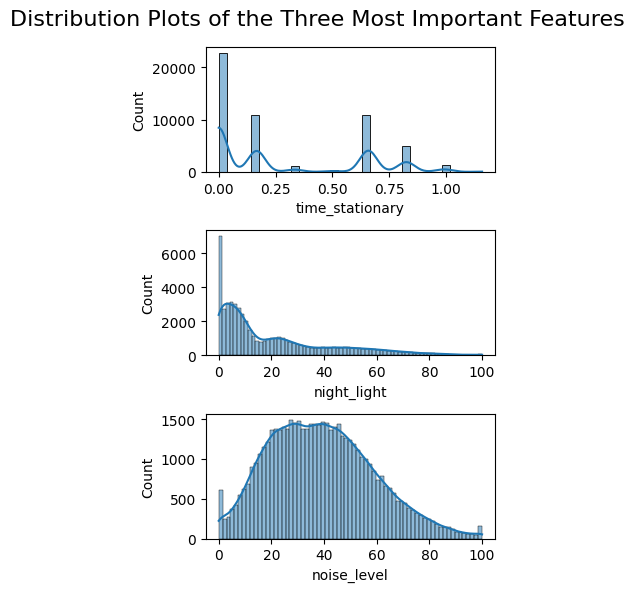

In [26]:
plt.figure(figsize=(4, 6))

plt.subplot(3, 1, 1)
sns.histplot(data[top_3_names[0]], kde=True)

plt.subplot(3, 1, 2)
sns.histplot(data[top_3_names[1]], kde=True)

plt.subplot(3, 1, 3)
sns.histplot(data[top_3_names[2]], kde=True)

plt.suptitle('Distribution Plots of the Three Most Important Features', fontsize=16)

plt.tight_layout()
plt.show()

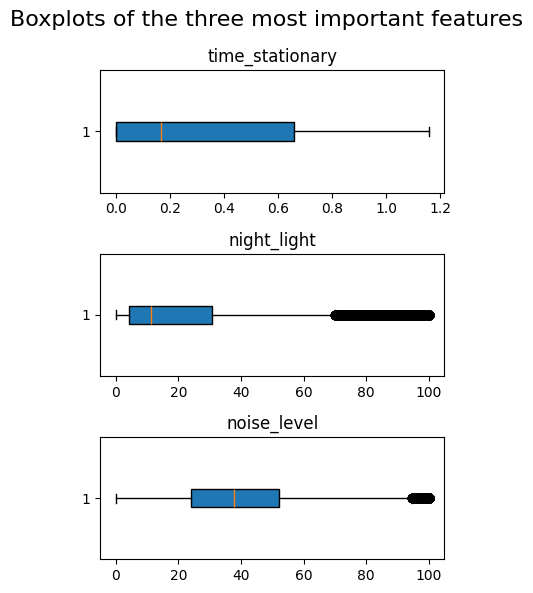

In [27]:
plt.figure(figsize=(4, 6))

plt.subplot(3, 1, 1)
plt.boxplot(data[top_3_names[0]], vert=False, patch_artist=True)
plt.title(top_3_names[0])

plt.subplot(3, 1, 2)
plt.boxplot(data[top_3_names[1]], vert=False, patch_artist=True)
plt.title(top_3_names[1])

plt.subplot(3, 1, 3)
plt.boxplot(data[top_3_names[2]], vert=False, patch_artist=True)
plt.title(top_3_names[2])

plt.suptitle('Boxplots of the three most important features', fontsize=16)

plt.tight_layout()
plt.show()